Robust regression
--------------

> Note: ``skscope`` also implemented an api [RobustRegression](../../../autoapi/skmodel.html#skscope.skmodel.RobustRegression) and now users can call it directly. 


### Introduction

Standard types of regression, such as ordinary least squares (OLS), have favourable properties if their underlying assumptions are true, but can give misleading results otherwise (i.e. are not robust to assumption violations). For example, the OLS estimates for regression models are highly sensitive to outliers: an outlier with twice the error magnitude of a typical observation contributes four (two squared) times as much to the squared error loss, and therefore has more leverage over the regression estimates.

Robust regression methods are designed to limit the effect that violations of assumptions by the underlying data-generating process have on regression estimates. The Huber or absolute-deviation loss function is a robust alternative to standard square error loss that reduces outliers' contributions to the squared error loss, thereby limiting their impact on regression estimates.
Specifically, the least absolute-deviation (LAD) regression is defined as:

$$\arg\min_{\beta}\| y - X\beta \|_{1},$$

and the Huber loss w.r.t. the residual $r=y-X\beta$ is defined as follows
$$
\text{Huber}(r;M)=\left\{
\begin{aligned}
&r^2, &|r|<M \\
&2M|r|-M^2, &|r|\geq M .\\
\end{aligned}
\right.
$$

### Sparse robust regression

To further accomodate the challenges of high-dimensionality, it is necessary to attach the sparsity constraint to perform sparse robust regression, which is formulated as:

$$\arg\min_{\beta} l(y - X\beta), \;\; \textup{s.t.} \;\; \|\beta\|_0 \leq s,$$

where $l(\cdot)$ is a robust loss function like least-absolute loss, Huber loss, or exponential square loss (ESL) [[1]](#refer-1). 

To show the powerfulness of sparse robust regression, we going to compare with sparse linear regression in a synthetic data with outliers. The synthetic dataset is a contaminated dataset, where the uncontaminated dataset is drawn from:

$$y' = X \beta +\epsilon,$$

where $X$ comes from a multivariate normal distribution and $\beta = (3, 3, 3, 0, 0, \ldots, 0)^\top$. The code for generating a uncontaminated dataset is given below.

In [1]:
import numpy as np

n, p = 500, 100
rng = np.random.default_rng(0)
X = rng.normal(0, 1, (n, p))
beta = np.zeros(p)
beta[:4] = [3, 3, 3, 3]
y = X @ beta + rng.normal(0, 1, n)

The contaminated dataset includes outliers, which is created by flipping the sign of 20% response:

In [2]:
flip_prob = rng.random(len(y))
y[flip_prob < 0.2] = -y[flip_prob < 0.2]

This result in a synthetic contaminated dataset with outliers, which is visualize below. 

<Axes: >

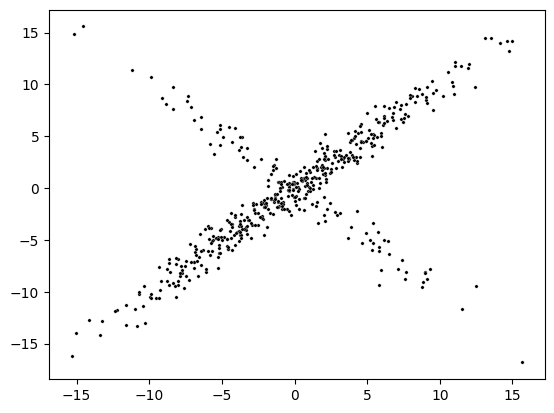

In [3]:
import seaborn as sns
sns.scatterplot(x=X @ beta, y=y, color='k', s=6)

Here, we show an example to perform the LAD regression, the Huber regression, the ESL regression with ``skscope``. We first implement the LAD, Huber and ESL loss: 

In [4]:
import jax.numpy as jnp

def lad_loss(params):
    return jnp.mean(jnp.abs(y - jnp.matmul(X, params)))

def huber_loss(params):
    M = 0.1
    r = y - jnp.matmul(X, params)
    loss = jnp.sum(jnp.piecewise(r, 
                                 [(r>=-M)&(r<=M), r<-M, r>M], 
                                 [lambda r: r**2, lambda r: 2*M*jnp.abs(r)-M**2, lambda r: 2*M*jnp.abs(r)-M**2]
                    )
            )
    return loss

def esl_loss(params):
    return jnp.mean(-jnp.exp(-jnp.square(y - jnp.matmul(X, params)) / 20.0))

Next, we initial a `ScopeSolver` that select 3 effective variables from $p$ variables. Then, these implemented loss functions are input into the solver to give three sparse robust coefficients estimator. And we can see that the estimation error is relatively small; particularly, the estimation error of the ESL regression is tiny and is better than the other two robust regressors. 

In [5]:
from skscope import ScopeSolver

solver = ScopeSolver(p, sparsity=5)
params_huber = solver.solve(huber_loss, jit=True)
params_lad = solver.solve(lad_loss, jit=True)
params_esl = solver.solve(esl_loss, jit=True)
print('Estimation Error (Huber): ', np.sum((params_huber-beta)**2).round(3))
print('Estimation Error (LAD): ', np.sum((params_lad-beta)**2).round(3))
print('Estimation Error (ESL): ', np.sum((params_esl-beta)**2).round(3))

Estimation Error (Huber):  0.196
Estimation Error (LAD):  0.198
Estimation Error (ESL):  0.029


We also perform the sparse linear regression below. But we can see that the estimated error is much larger. 

In [7]:
def ols_loss(params):
    loss = jnp.mean((y - X @ params)**2)
    return loss

params_ols = solver.solve(ols_loss, jit=True)
print('Estimation Error (OLS): ', np.sum((params_ols-beta)**2).round(3))

Estimation Error (OLS):  6.736


Next, we compare regression models estimated under different loss function. 

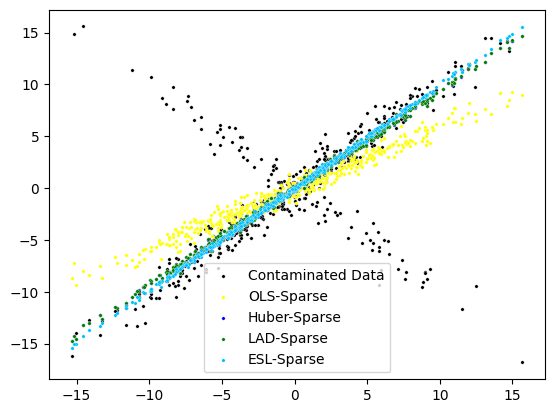

In [21]:
import matplotlib.pyplot as plt
sns.scatterplot(x=X @ beta, y=y, color='k', label='Contaminated Data', s=6)
sns.scatterplot(x=X @ beta, y=X @ params_ols, color='yellow', label='OLS-Sparse', s=6)
sns.scatterplot(x=X @ beta, y=X @ params_huber, color='blue', label='Huber-Sparse', s=6)
sns.scatterplot(x=X @ beta, y=X @ params_lad, color='green', label='LAD-Sparse', s=6)
sns.scatterplot(x=X @ beta, y=X @ params_esl, color='deepskyblue', label='ESL-Sparse', s=6)
plt.legend()
plt.show()

We can witness that the robust estimations are insensitive to the outliers and estimated models are closed to the true linear model (i.e., the model for generating the uncontaminated dataset). Unfortunately, the standard sparse linear regression largely deviate the underlying true model. Moreover, we can see that the sparse ESL regression is closest to the true one because [[1]](#refer-1) proves the ESL based robust variable selection can achieve the highest asymptotic breakdown point of 1/2 and that their influence functions are bounded with respect to the outliers in either the response or the covariate domain.

### Reference

<div id="refer-1"></div>

- [1] Xueqin Wang, Yunlu Jiang, Mian Huang & Heping Zhang (2013) Robust Variable Selection With Exponential Squared Loss, Journal of the American Statistical Association, 108:502, 632-643, DOI: 10.1080/01621459.2013.766613

